# EllaBot Report
## Introduction

In the search and rescue task, an agent is presented a navigation target which it must reach as quickly as possible. We developed approaches using Sarsa(λ) with value function approximation and policy gradient methods. Neither of these methods alone is suitable for learning in varied environments. We investigated the use of a lifelong learning algorithm with policy gradients, PG-ELLA, to facilitate sharing knowledge across different parameterizations of our environment. The code for our simulation and learning algorithms as well as the source for this report are available on [our GitHub](http://github.com/EllaBot/).


### World and Task
The Room World is a rectangular space in which the agent and a goal are placed. Different coefficients of ground friction can be set to affect the ability of an agent to move in certain directions. The world can be setup as follows:

In [1]:
%matplotlib inline
from worldsim import WorldSim
from worldsim.experiments import experiment_runner,  plot_utils
from worldsim.agents import SarsaAgent, State, PGPEAgent, ActorCriticAgent
from worldsim.tasks import SearchTask
from true_online_td_lambda.optimization import l_bfgs
from random import random
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 8, 6

Agents can manipulate the world by sending commands. The world then provides them with observations which they may use in the process of deciding their next action. The learning agents we present use states consisting of distance and clockwise angle to goal, and actions consisting of angular and linear velocities on the interval [-1.5, 1.5]. This formulation is consistent with the capabilities of the TurtleBots and SegBots.

The reward function used by the agents is given by

$$
   r(s_t, a_t, s_{t+1}) = \left\{
     \begin{array}{lr}
       100 & : d < 0.55 \ and \  \omega < 0.22\\
       -d + -0.5\ |v| & : otherwise
     \end{array}
   \right.
$$ 

### Learning

We used an $\epsilon$-greedy policy, selecting actions that maximize the value function (with probability $1 - \epsilon$), and random actions otherwise.

In order to maximize the value function, we needed to find the following, where **S**, **A** correspond to the state and action vectors, respectively.

$$\underset{\textbf{A}} {\mathrm{argmax}} ~\hat{V}(\textbf{S}, \textbf{A}) = \underset{\textbf{A}} {\mathrm{argmax}} ~\theta^{\top}\phi(\textbf{S}, \textbf{A})$$

The solution requires the gradient of the value function, $\hat{V}$, which can be found by differentiating $\phi$ w.r.t **A**:

$$\phi(\textbf{S}, \textbf{A}) = \cos(\pi \textbf{c} \cdot (\textbf{S}, \textbf{A}))$$

$$\frac{\partial \ \phi(\textbf{S}, \textbf{A})}{\partial \ \textbf{A}} = -\pi\textbf{c}\sin(\pi \textbf{c} \cdot (\textbf{S}, \textbf{A}))$$

So:

$$\nabla_{\textbf{A}}\hat{V}(\textbf{S}, \textbf{A}) = -\theta^{\top}\pi\textbf{c}\sin(\pi \textbf{c} \cdot (\textbf{S}, \textbf{A}))$$

Next, we used a convex optimization method, L-BFGS, to maximize $\hat{V}$. This is a quasi-Newton method which uses hessian approximations to guide convergence.

Now, let's run an experiment with 150 episodes to see if the agent learns:

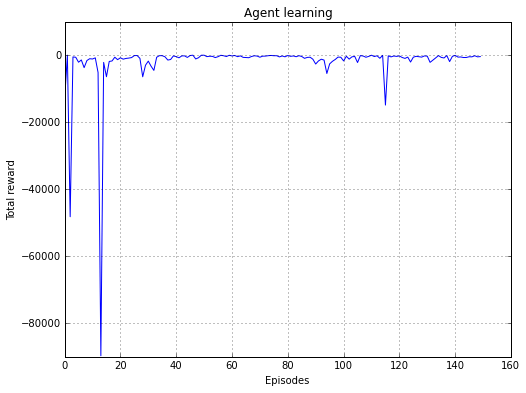

In [2]:
world = WorldSim(10.0, 10.0)  # 10m x 10m world
task = SearchTask(5.0, 5.0)
agent = SarsaAgent(world, task)
rewards = experiment_runner.run_experiment(agent, world, episodes=150, maximize=l_bfgs.maximize)

# Plot results
plot_utils.plot_rewards(rewards)

The eratic performance of the agent seems to indicate that it is not learning. Upon further investigation, we found that the convex optimizer was getting stuck at local maxima. This, as we discovered, was because the value function, based on the Fourier basis, is not convex. The Fourier basis paper talks about tasks that have continuous states, but *discrete* actions, making convexity a non-issue. However, our task has both continuous states and actions.

We used two approaches to solve this problem. First, we used a naïve brute force approach, exhaustively searching for the maximum by plugging linear and angular velocities into the value function. This solution is imprecise and very slow. In our second approach, we combined a brute force search with convex optimization. Essentially, we found the rough maximum via brute force, and then used that rough maximum as the initial guess for L-BFGS. L-BFGS then finds the nearest maximum, which is likely to be the global maximum. This alleviates some of the issues with normal brute force searching: it is faster since the increments need not be very small (since we just want a rough maximum), and it is more accurate since L-BFGS is finding the global maximum at the end.

The experiment again with our second optimization strategy:

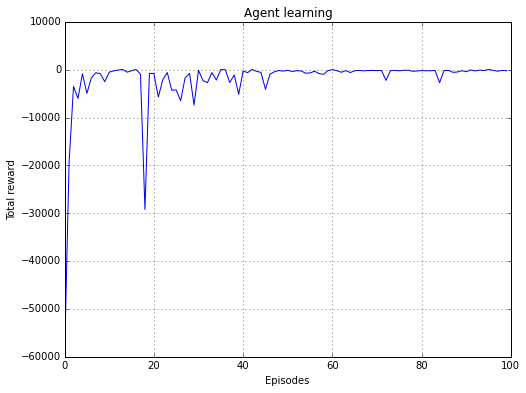

In [3]:
world = WorldSim(10.0, 10.0)  # 10m x 10m world
task = SearchTask(5.0, 5.0)  # Goal placed at (5,5)
agent = SarsaAgent(world, task)
rewards = experiment_runner.run_experiment(agent, world, episodes=100)

# Plot results
plot_utils.plot_rewards(rewards)

The quick uptick in the total reward per episode shows that the agent is learning. As further evidence, distance per step, a measurement which indicates the efficiency of the agents movement, also displays a positive trend. However, even this graph, which is averaged over the learning of five agents, has significant variance. This is largely attributable to the agent's random initial angle to the goal, prevents it from reaching the theoretical cap for our simulation of 0.15.

<img src="https://raw.githubusercontent.com/EllaBot/Report/master/images/distanceperstepsplot.png" width="600">

<img src="https://raw.githubusercontent.com/EllaBot/Report/master/images/learned_path.png" width="600">

While our second approach is superior to a naïve brute force search, there are still better methods to use. For instance, basin hopping [3], a Monte Carlo method used in many physics and chemistry problems, finds the global maximum by randomly perturbing coordinates; specifically, it finds the local maximum, and accepts or rejects new coordinates based on the Metropolis criterion. This method would be faster than our second approach. Furthermore, the independence of value function calculations presents an opportunity for massive parallelization via the GPU.

## Policy Gradient with Parameter Exploration

The high complexity of approximating and maximizing a value function in our simple, four-feature case belies the futility of value function approaches for higher dimensional tasks. Policy gradient methods have demonstrated promise for complex tasks, so they presented a natural next option for a solution to the search and rescue task. Instead of searching the space of all possible value functions, which may be exponential in the number of features, policy gradient methods search in policy space, modifying parameterized policies and observing the change in the reward.

Our first policy gradient agent used Policy Gradient with Parameter-based Exploration (PGPE), which, in a slight simplification of general PG methods, searches directly in model parameter space. An agent uses a controller with a Gaussian policy, picking actions from normals with means given by linear combinations of the state features and the learned parameters. The variances of the distributions are fixed.

$\pi _{\theta} (s, \cdot) \sim\ \mathcal{N}( \theta^\top\phi(s), \sigma^2)$

Two pertubations of the parameters are produced, shifting the parameters slightly up and slightly down. Two rollouts are conducted with policies determined by these parameters, and the resulting rewards are used to estimate the gradient of the agent's expected return. The learned theta is updated with an $\alpha$ step size, and the process is repeated.

An important benefit of this approach is that elements of the weight vector have comprehensible effects on the policy. This allows us to provide a reasonable initial theta based on our knowledge of the problem, greatly speeding learning. In the absence of a reasonable theta, inital rollouts tend to adopt incredibly ineffective policies. We cap the the number of steps in an episode to 400 to mitigate this.

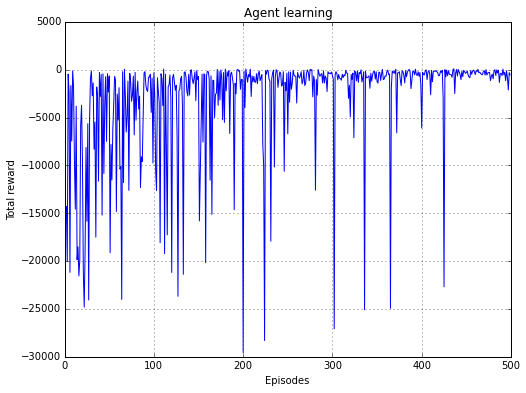

In [ ]:
world = WorldSim(10.0, 10.0)  # 10m x 10m world
task = SearchTask(5.0, 5.0)  # Goal placed at (5,5)
agent = PGPEAgent(world, task)
rewards = experiment_runner.run_experiment_capped(agent, world, episodes=500, maxsteps=2500)

# Plot results
plot_utils.plot_rewards(rewards)

The lack of intra-episode learning makes this method computationally efficient, but unsuited for a fully autonomous learning agent.

## Actor-Critic Policy Gradient

The two previous approaches are often described slightly different terms. Value function approximation approaches that use temporal-difference learning are called *critic* methods, while approaches that optimize over parameterized policies are typically called *actor* methods. Perhaps unsuprisingly, the advantages of both approaches can be leveraged with actor-critic methods. The critic can supply the actor with low-variance knowledge of its performance, shifting performance as it updates the value function. After a period, the critic receives the updated parameters and performs its own updates.

In [ ]:
world = WorldSim(10.0, 10.0)  # 10m x 10m world
task = SearchTask(5.0, 5.0)  # Goal placed at (5,5)
agent = ActorCriticAgent(world, task)
rewards = experiment_runner.run_experiment(agent, world, episodes=300)

# Plot results
plot_utils.plot_rewards(rewards)

Though this approach seems to make efficient use of the information available to the agent, however, there is still room for improvement.

## Multi-task Learning with Sarsa Efficient Life-long Learning Algorithm (SELLA)

Our simplistic version of the search and rescue problem ignores an important characteristic of the problem; a search and rescue agent will be expected to adapt to environments with altered characteristics. The previously presented solutions are fitted to the properties of the environment, meaning that even new tasks that are clearly adjacent must be painstakingly relearned. 

Certainly there is shared structure between the tasks, and algorithms exist that exploit this to accelerate learning. Thus far, Efficient Life-long Learning (ELLA) is one of the only such algorithms that has reasonable performance characteristics. ELLA forms weight vectors for a task from a latent basis, integrating learning from a single-task learner into its knowledgebase after rollouts. It has been shown to be successful in generalizing learning across tasks in the same state and action spaces.

We investigated PG-ELLA, which is simply ELLA using a policy gradient single-task learner, but we became interested

## References 

[1] Seijen, Harm V., and Rich Sutton. "True Online TD (lambda)." Proceedings of the 31st International Conference on Machine Learning (ICML-14). 2014.

[2] Konidaris, George. "Value function approximation in reinforcement learning using the Fourier basis." 2008.

[3] D.J. Wales and J.P.K. Doye, “Global optimization by basin-hopping and the lowest energy structures of Lennard-Jones clusters containing up to 110 atoms,” J. Phys. Chem. A 101, 5111. 1997. doi:10.1021/jp970984n

[4] Frank Sehnke, Christian Osendorfer, Thomas Ru ̈ckstieß, Alex Graves, Jan Peters, and Ju ̈rgen Schmidhuber. "Policy gradients with parameter-based exploration for control". Proceedings of the International Conference on Artificial Neural Networks (ICANN). 2008.

[5] Ammar, Eaton, E.; Ruvolo, P.; and Taylor, M.. "Online multi-task learning for policy gradient methods". Proceedings of the 31st International Conference on Machine Learning. 2014.

[6] Ruvolo, P., and Eaton, E.. "ELLA: An efficient lifelong learning algorithm". Journal of Machine Learning Research. 2013.

[7] Grondman, I., Busoniu, L., Lopes, G. A. D., and Babuska, R.. "A survey of actor-critic rein- forcement learning: Standard and natural policy gradients". Systems, Man, and Cybernetics, Part C: Applications and Reviews, IEEE Transactions on, 42(6):1291–1307. 2012

[8] T. Schaul, J. Bayer, D. Wierstra, Y. Sun, M. Felder, F. Sehnke, T. Ru ̈ckstieß, and J. Schmidhuber. "PyBrain". The Journal of Machine Learning Research, 11:743–746. 2010.